In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from _bootstrap import *
from community_detection import (
    CommunityDetector,
    PolygonDissolver,
    GraphConstructor)
from paths import get_paths

input_dir, output_dir, plots_dir = get_paths()

In [2]:
target_pop = 1000

matrix = pd.read_parquet(output_dir / "matrices.parquet")

# Select matrix
matrix = matrix.loc[matrix["target_pop"]==target_pop].copy()

tracts = gpd.read_file(output_dir / "tracts.gpkg", layer=f"tracts_{target_pop}")
tracts["TractID"] = tracts["TractID"].astype(str)

matrix["TractID_1"] = matrix["TractID_1"].astype(str)
matrix["TractID_2"] = matrix["TractID_2"].astype(str)

gc = GraphConstructor(matrix, weights_col="combined_score")
gc.build_graph()
G = gc.get_graph()

In [3]:
# Model without spatial enforcement
cd = CommunityDetector(G, tracts, trials=30)
result, score, time = cd.run_infomap(return_codelength=True, preferred_modules=39, measure_time=True,
                                     enforce_spatial=False)

df = pd.DataFrame(result.items(), columns=["TractID", "community"])
# Create the Community Polygons
polygon_dissolver = PolygonDissolver(tracts)
pcsa_def = polygon_dissolver.process_community_outcomes(communities=df, verbose=False)
print("No. of Communities:",len(pcsa_def))

No. of Communities: 39


In [4]:
# Spatial enforcement using the minimal impact score
cd = CommunityDetector(G, tracts, trials=30)
result, score, time = cd.run_infomap(return_codelength=True, preferred_modules=39, measure_time=True,
                                     enforce_spatial=True, strategy="min_impact_score")

df = pd.DataFrame(result.items(), columns=["TractID", "community"])
# Create the Community Polygons
polygon_dissolver = PolygonDissolver(tracts)
pcsa_mis = polygon_dissolver.process_community_outcomes(communities=df, verbose=False)
print("No. of Communities:",len(pcsa_mis))

No. of Communities: 38


In [5]:
# Spatial enforcement using the strongest connection
cd = CommunityDetector(G, tracts, trials=30)
result, score, time = cd.run_infomap(return_codelength=True, preferred_modules=41, measure_time=True,
                                     enforce_spatial=True, strategy="strongest_connection")

df = pd.DataFrame(result.items(), columns=["TractID", "community"])
# Create the Community Polygons
polygon_dissolver = PolygonDissolver(tracts)
pcsa_sc = polygon_dissolver.process_community_outcomes(communities=df, verbose=False)
print("No. of Communities:",len(pcsa_sc))

No. of Communities: 38


In [6]:
all_categories = sorted(set(pcsa_def['community']) | set(pcsa_mis['community']) | set(pcsa_sc['community']))

# Generate color map
cmap = plt.get_cmap('tab20b')
color_dict = {cat: cmap(i % cmap.N) for i, cat in enumerate(all_categories)}

# Add a color column to each GeoDataFrame
for gdf in [pcsa_def, pcsa_mis, pcsa_sc]:
    gdf['color'] = gdf['community'].map(color_dict)

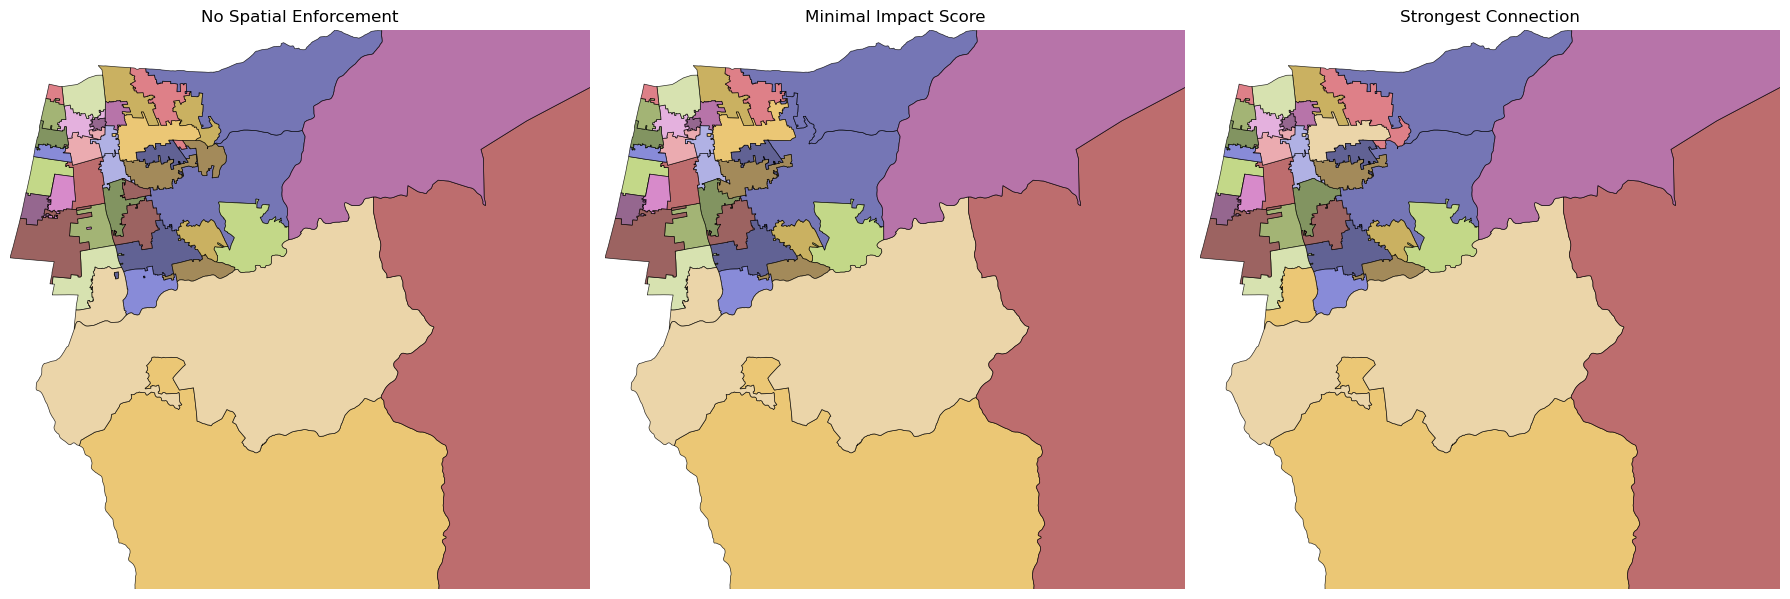

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

urban_comms = ['PUENTE ALTO', 'SAN RAMÓN', 'LA FLORIDA', 'LA PINTANA',
       'LA GRANJA']
gdfs = [pcsa_def, pcsa_mis, pcsa_sc]
titles = ['No Spatial Enforcement', 'Minimal Impact Score', 'Strongest Connection']
#titles = ['A', 'B', 'C']

for ax, gdf, title in zip(axes, gdfs, titles):
    urban_pcsas = gdf.loc[gdf.commune.isin(urban_comms)]
    gdf.plot(color=gdf['color'], ax=ax, edgecolor='black', linewidth=0.5, legend=False, alpha=0.8)
    minx, miny, maxx, maxy = urban_pcsas.total_bounds
    ax.set_xlim(minx, maxx + 12000)
    ax.set_ylim(miny - 15000, maxy)
    ax.set_title(title)
    ax.axis('off')

plt.subplots_adjust(wspace=0.01)
plt.tight_layout()
plt.savefig(plots_dir / "spatial_enforcement.png", dpi=300, bbox_inches='tight')
plt.show()